In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import distance
import seaborn as sns
from scipy.sparse import csr_matrix,hstack
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

from utils import *
from sklearn.preprocessing import StandardScaler
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import contractions
from fuzzywuzzy import fuzz
import re
import string 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.corpus import stopwords
# stopwords = stopwords.words('english')

import nltk
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

C:\Users\lengo\miniconda3\envs\torch\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
stopwords = pd.read_csv('my_stopword.csv')
stopwords = stopwords['0'].tolist()

### Load data and analyze

In [3]:
data_path = 'D:\\FSOFT_QAI\\text analysis\\quora-question-pairs\\'

In [4]:
data = pd.read_csv(data_path + 'train.csv')

In [5]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

### Data Visualization

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



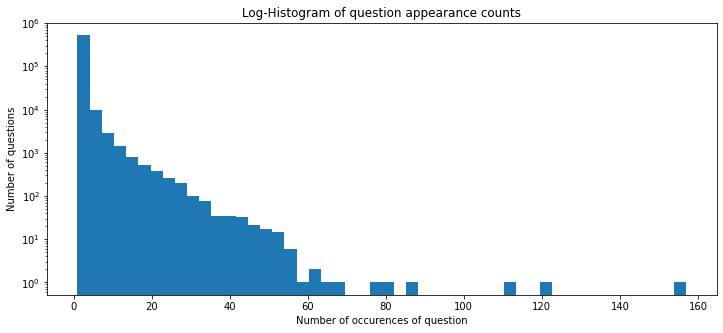

In [8]:
print('Total number of question pairs for training: {}'.format(len(data)))
print('Duplicate pairs: {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())

print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

==> từ biểu đồ chúng ta có thể thấy số lần xuất hiện các câu hỏi tỉ lệ nghịch với số lượng câu hỏi (số lần xuất hiện càng cao thì số lương càng ít)

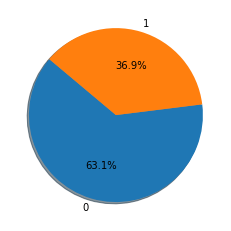

In [9]:
duplicate_count = data['is_duplicate'].value_counts()
plt.pie(duplicate_count, labels=duplicate_count.index,
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [10]:
print('Number of duplicate question: {}'.format(data[data['is_duplicate'] == 1].count()[0]))
print('Number of non duplicate question: {}'.format(data[data['is_duplicate'] == 0].count()[0]))

Number of duplicate question: 149263
Number of non duplicate question: 255027


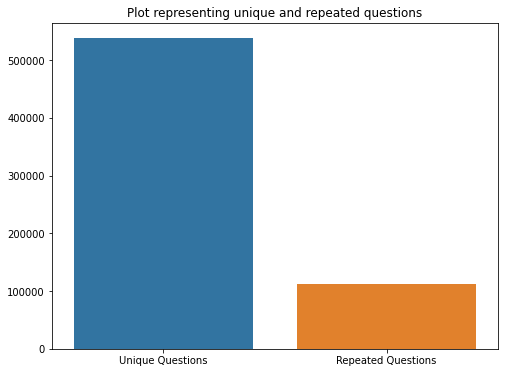

In [11]:
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)

x = ["Unique Questions","Repeated Questions"]
y = [unique_qs,qs_morethan_onetime]
plt.figure(figsize=(8,6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

In [12]:
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



**Tiếp theo chúng ta dùng WordCloud để có cái nhìn tổng quan về những từ lặp lại thường xuyên trong kho dữ liệu (text corpus)**

(-0.5, 399.5, 199.5, -0.5)

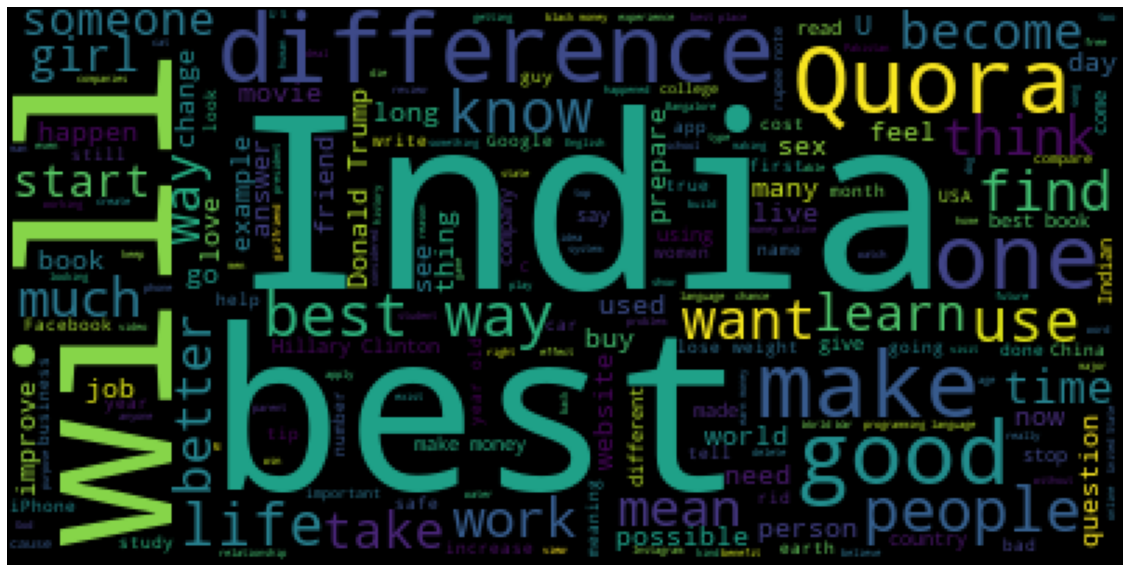

In [13]:
from wordcloud import WordCloud
train_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)

cloud = WordCloud().generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

==> Những từ có kích thước lớn là những từ hay xuất hiện trong cặp câu hỏi trùng nhau

### Data Processing

**Creating some numerical features**
- freq_qid1: Frequency of qid1's
- freq_qid2: Frequency of qid2's
- q1len: Length of q1
- q2len: Length of q2
- q1_n_words: Number of words in Question 1
- q2_n_words: Number of words in Question 2
- word_Common: (Number of common unique words in Question 1 and Question 2)
- word_Total: (Total num of words in Question 1 + Total num of words in Question 2)
- word_share: (word_common)/(word_Total)
- freq_q1+freq_q2: sum total of frequency of qid1 and qid2
- freq_q1-freq_q2: absolute difference of frequency of qid1 and qid2
- cosin similarity

In [14]:
# Handle missing valuse before applying
data = data.fillna('')

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))



data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))
data['word_Common'] = data.apply(normalized_word_Common, axis=1)
data['word_Total'] = data.apply(normalized_word_Total, axis=1)
data['word_share'] = data.apply(normalized_word_share, axis=1)
data['freq_q1+q2'] = data['freq_qid1'] + data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1'] - data['freq_qid2'])


In [15]:
data["token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
data["token_sort_ratio"]= data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
data["fuzz_ratio"] = data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

In [16]:
def similar_cosin(X, Y):
    X_list = word_tokenize(X) 
    Y_list = word_tokenize(Y)
    # sw contains the list of stopwords
    l1 =[]; l2 =[]
    # remove stop words from the string
    X_set = {w for w in X_list if not w in stopwords} 
    Y_set = {w for w in Y_list if not w in stopwords}
    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0
    # cosine formula 
    for i in range(len(rvector)):
            c += l1[i]*l2[i]
    denominator = float((sum(l1)*sum(l2))**0.5)
    if denominator != 0:
        cosine = c / float((sum(l1)*sum(l2))**0.5)
    else: cosine = 0.0   
    return cosine

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [1]:
data["longest_substr_ratio"] = data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
data['cosin_similar'] = data.apply(lambda x: similar_cosin(x['question1'],x['question2']),axis=1)
data['both_questions'] = data.apply(lambda x: x['question1'] +' '+  x['question2'], axis=1)

In [ ]:
data.head(2)

**Sau khi tạo một vài numerical features, tiếp theo ta sẽ cleaning text**
- Removing html tags
- Word repetition
- Removing Punctuations
- Performing Stemming
- Removing Stopwords
- Expanding contractions etc.

In [ ]:
def utils_preprocess_text(txt, lst_regex=None, punkt=True, lower=True, 
                          slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ## regex (in case, before processing)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)

    ## clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## remove leftover Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]

    # ## back to string from list
    txt = " ".join(lst_txt)
    return txt

In [3]:
data['text_clean'] = data['both_questions'].apply(lambda x : utils_preprocess_text(x, lst_regex=None, punkt=True, 
                                                    lower=True, slang=True, lst_stopwords=stopwords, stemm=False, lemm=True))

In [24]:
data.head(2)

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,cosin_similar,text_clean
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,100,93,93,98,0.965517,0.935414,step step guide invest share market india step...
1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,86,63,66,73,0.442308,0.588348,story kohinoor kohinoor diamond would happen i...


In [32]:
data = data.fillna('')

In [33]:
data['tokens'] = data['text_clean'].apply(lambda x : word_tokenize(x))

In [34]:
data.head(2)

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,cosin_similar,text_clean,tokens
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,100,93,93,98,0.965517,0.935414,step step guide invest share market india step...,"[step, step, guide, invest, share, market, ind..."
1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,86,63,66,73,0.442308,0.588348,story kohinoor kohinoor diamond would happen i...,"[story, kohinoor, kohinoor, diamond, would, ha..."


In [35]:
y = data['is_duplicate']
X = data.drop(['is_duplicate'], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(323432, 19) (80858, 19) (323432,) (80858,)


In [41]:
X_train_basic_feature = X_train[X.columns[:-2]]
X_test_basic_feature = X_test[X.columns[:-2]]

In [42]:
X_train_basic_feature.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,cosin_similar
352886,2,1,35,54,7,10,4.0,17.0,0.235294,3,1,89,69,67,83,0.388889,0.755929
134949,4,1,30,31,6,5,2.0,11.0,0.181818,5,3,78,75,71,63,0.354839,0.182574


In [43]:
X_train_basic_feature_spare = csr_matrix(X_train_basic_feature)
X_test_basic_feature_spare = csr_matrix(X_test_basic_feature)

## Vectorization

In [44]:
X_train = X_train.drop(X_train.columns[:-1],axis=1)
X_test = X_test.drop(X_test.columns[:-1],axis=1)

**Duplicate/Unduplicate Frequency**

In [45]:
def build_freqs(tweet_list, sentiment_list):
    freqs = {}
    for tweet, sentiment in zip(tweet_list, sentiment_list):
        for word in tweet:
            pair = (word, sentiment)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [46]:
def tweet_to_freq(tweet, freqs):
    x = np.zeros((2,))
    for word in tweet:
        if (word, 1) in freqs:
            x[0] += freqs[(word, 1)]
        if (word, 0) in freqs:
            x[1] += freqs[(word, 0)]
    return x

In [47]:
freqs = build_freqs(X_train['tokens'], y_train)

In [48]:
black_word_02 = [word for (word, duplicate), num in freqs.items() if num < 10]

In [ ]:
X_train_pn = [tweet_to_freq(tweet, freqs) for tweet in X_train['tokens']]
X_test_pn = [tweet_to_freq(tweet, freqs) for tweet in X_test['tokens']]

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_pn_all = scaler.fit_transform(hstack([X_train_pn, X_train_basic_feature_spare]))
X_test_pn_all = scaler.fit_transform(hstack([X_test_pn, X_test_basic_feature_spare]))

**Bag of Word**

In [ ]:
bow = CountVectorizer(tokenizer=lambda x: x,
                      preprocessor=lambda x: x, ngram_range=(1,1))
bow.fit(X_train['tokens'])

In [ ]:
len(bow.get_feature_names())

In [ ]:
X_train_bow = bow.transform(X_train['tokens'])
X_test_bow = bow.transform(X_test['tokens'])

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_bow_all = scaler.fit_transform(hstack([X_train_bow, X_train_basic_feature_spare]))
X_test_bow_all = scaler.fit_transform(hstack([X_test_bow, X_test_basic_feature_spare]))

**TF-IDF**

In [ ]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x,
                      preprocessor=lambda x: x, ngram_range=(2,2))
tfidf.fit(X_train['tokens'])

In [ ]:
len(tfidf.get_feature_names())

In [ ]:
X_train_tfidf = tfidf.transform(X_train['tokens'])
X_test_tfidf = tfidf.transform(X_test['tokens'])

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_tfidf_all = scaler.fit_transform(hstack([X_train_tfidf, X_train_basic_feature_spare]))
X_test_tfidf_all = scaler.fit_transform(hstack([X_test_tfidf, X_test_basic_feature_spare]))

**All feature**

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_all = scaler.fit_transform(hstack((X_train_pn, X_train_bow, X_train_tfidf, X_train_basic_feature_spare)))
X_test_all = scaler.fit_transform(hstack((X_test_pn, X_test_bow, X_test_tfidf, X_test_basic_feature_spare)))

In [ ]:
X_train_all.shape

# Lựa chọn và đánh giá mô hình

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
# Số fold bằng 3
def estimate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    return report, model

### Huấn luyện mô hình

In [ ]:
def plot_confusion(cm):
    plt.figure(figsize = (5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.title("Confusion Matrix")
    return sns

**4. RandomForest**

In [ ]:
model_forest = RandomForestClassifier(n_estimators = 100, max_features = 'log2', random_state = 42)

print(f'Accuracy for Frequency\n: {estimate(model_forest, X_train_pn_all, y_train, X_test_pn_all, y_test)}')
print(f'Accuracy for Bag of Word\n: {estimate(model_forest, X_train_bow_all, y_train, X_test_bow_all, y_test)}')
print(f'Accuracy for TF-IDF\n: {estimate(model_forest, X_train_tfidf_all, y_train, X_test_tfidf_all, y_test)}')

print(f'Accuracy for All feature:\n {estimate(model_forest, X_train_all, y_train, X_test_all, y_test)}')

In [ ]:
plot_confusion(confusion_matrix(y_test, model_forest.predict(X_test_bow_all)));

In [ ]:
# print(X_test[100:110])
# print(y_test[100:110])

In [ ]:
# model_forest.predict(X_test_bow_all[100:110])

In [ ]:
# model_forest.predict_proba(X_test_bow_all[100:110])